# Sound classification with YAMNet

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import pandas as pd
from scipy import signal
import scipy

2023-02-01 18:23:26.259637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 18:23:26.847859: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-01 18:23:28.308358: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-01 18:23:28.308505: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
# Load the model

model = hub.load("https://tfhub.dev/google/yamnet/1")

2023-02-01 18:23:36.907417: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-01 18:23:36.907576: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (suhun-GL62-6QE): /proc/driver/nvidia/version does not exist
2023-02-01 18:23:36.910958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class_map_path = model.class_map_path()
class_map_path

<tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/tfhub_modules/9616fd04ec2360621642ef9455b84f4b668e219e/assets/yamnet_class_map.csv'>

텐서플로우에서 미리 학습 시켜놓은 모델이 다양하다.모델만 들어있는것이 아닌 csv파일에 학습된 클래스정보가 들어있다.

In [5]:
# Find the name of the class with the top when mean-aggregated across frame.
def class_names_from_csv(class_map_csv_text):
    class_names = []
    with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            class_names.append(row["display_name"])
    return class_names

- pandas 데이터프레임으로 파일을 로드해서 어떤 클래스가 있는지 확인해보자.
- 로드된 오디오가 적절한 sample_rate(16k)인지 확인하고 변환하는 메서드를 추가한다. resample를 하지 않으면 모델의 결과에 영향을 줄 수 있다.

In [6]:
class_map_path = model.class_map_path().numpy()
# numpy에 경로가 들어있다.
class_names = class_names_from_csv(class_map_path)
#class_names에 append 된 리스트 값이 들어있다.

In [7]:
def ensure_sample_rate(original_sample_rate, waveform,
                      desired_sample_rate = 16000):
    """Resample waveform if required"""
    if original_sample_rate !=desired_sample_rate:
        desired_length = int(round(float(len(waveform)) /
                                   original_sample_rate *desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return desired_sample_rate, waveform

# 사운드 파일 다운로드 및 준비
- 클래스가 다양하게 학습되어 있기때문에 다양한 소리들을 predict해보면 좋습니다. 전 제 음성파일을 가지고 사용했습니다 
- 16KHZ의 샘플레이트에서 모노wav파일이어야 합니다.

In [8]:
# wav 파일 로드
wav_file_name = "/data11/음성파일/치매원본음성/original/ALL/1/AD/13827.1.wav"
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 5.57s
Size of the input: 89088


In [22]:
# 스케일링 수행 -1~1사이의 값으로 변경한다.
# 그림이든 오디오든 스케일링은 필수!
# 개똥점수를 보지 않으려면 무조건 해야한다.
waveform=wav_data/tf.int16.max 

In [10]:
waveform

array([ 0.00177696, -0.00039652,  0.00019444, ...,  0.00845282,
        0.0070493 ,  0.00694774])

In [11]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [29]:
embeddings.numpy()

array([[0.        , 0.40697682, 0.24601571, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0487691 , 0.        , ..., 0.        , 0.00740994,
        0.        ],
       [0.11500186, 0.448575  , 0.39356303, ..., 0.        , 0.070938  ,
        0.        ],
       ...,
       [0.        , 0.2771222 , 0.03031337, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.10201842, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.03757147, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [28]:
spectrogram.numpy().min()

-6.9077554

In [12]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Speech


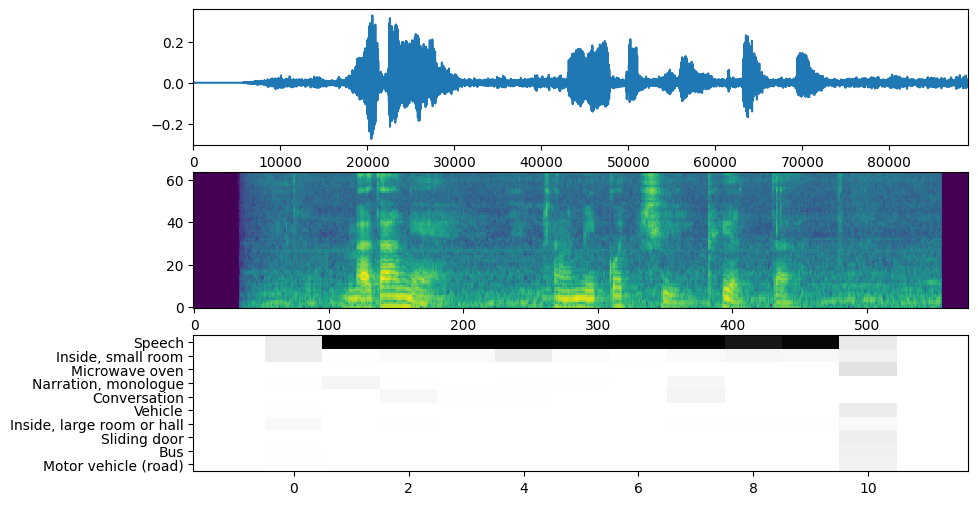

In [30]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))

# conclusion
> 최종 결과 speech로 잘 나왔다. 다중클래스 분류다 보니 유사한 다른 클래스들도 함께 출력되는데 잡음이 포함되어 있어 클래스에 포함되는것으로 생각된다.